# Import FLD methods from script

In [127]:
from FLD_methods import *
import os

# Get the SCOPE simulations of 16 different crop types

In [128]:
scope_crops = '/Users/jameswallace/Desktop/SCOPE_crops' # get the folder containing the SCOPE sims

In [129]:
from glob import glob
folders = glob("/Users/jameswallace/Desktop/SCOPE_crops/*/")  

In [130]:
# get the correct files
def get_spectra_pathnames(dir_pathname):
    folders = glob(dir_pathname + '/*/')
    e_sun_pathnames, e_sky_pathnames, l_pathnames, f_pathnames = [], [], [], []
    for sub_dir in folders:
        e_sun_pathnames.append(sub_dir + 'Esun.csv')
        e_sky_pathnames.append(sub_dir + 'Esky.csv') # total E = Esun + Esky
        l_pathnames.append(sub_dir + 'Lo_spectrum_inclF.csv')
        f_pathnames.append(sub_dir + 'fluorescence_scalars.csv')
    return(e_sun_pathnames, e_sky_pathnames, l_pathnames, f_pathnames)

In [131]:
e_sun_pathnames, e_sky_pathnames, l_pathnames, f_pathnames = get_spectra_pathnames(scope_crops) # get pathnames

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_unstressed_bean/Lo_spectrum_inclF.csv


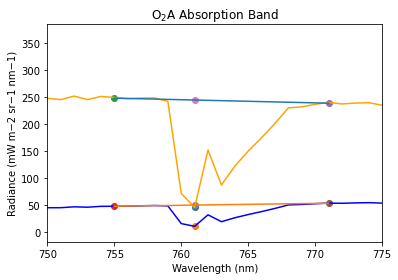

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_stressed_wheat/Lo_spectrum_inclF.csv


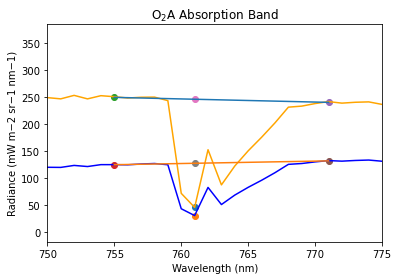

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_unstressed_bean/Lo_spectrum_inclF.csv


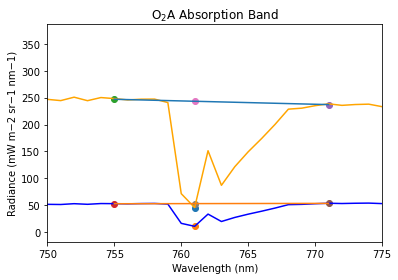

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_stressed_bean/Lo_spectrum_inclF.csv


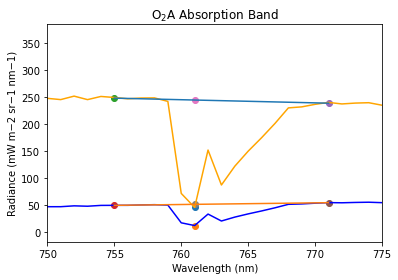

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_stressed_wheat/Lo_spectrum_inclF.csv


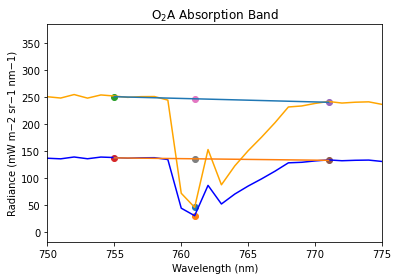

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_stressed_bean/Lo_spectrum_inclF.csv


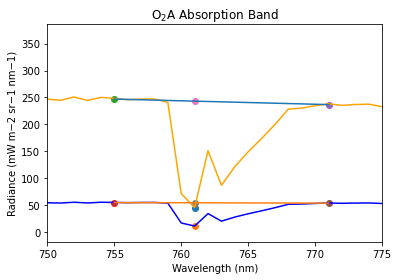

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_unstressed_wheat/Lo_spectrum_inclF.csv


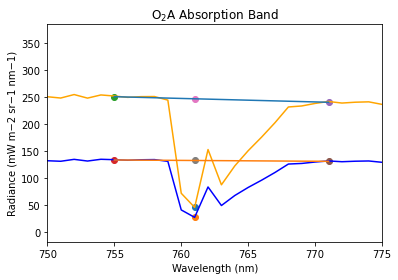

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_unstressed_bean/Lo_spectrum_inclF.csv


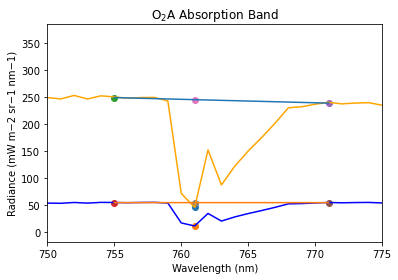

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_unstressed_wheat/Lo_spectrum_inclF.csv


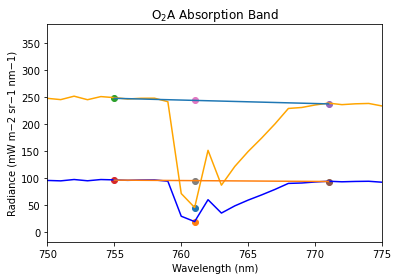

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_stressed_wheat/Lo_spectrum_inclF.csv


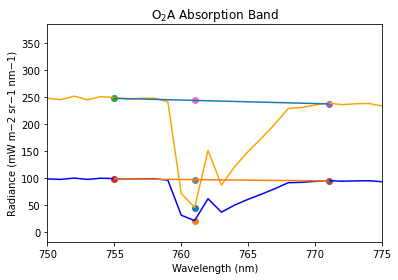

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_unstressed_wheat/Lo_spectrum_inclF.csv


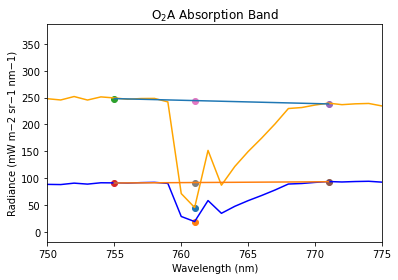

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_stressed_bean/Lo_spectrum_inclF.csv


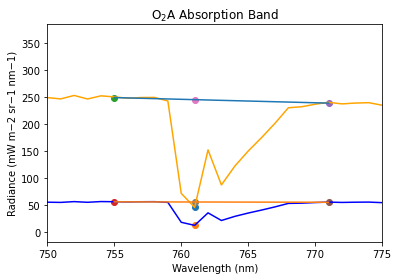

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_unstressed_wheat/Lo_spectrum_inclF.csv


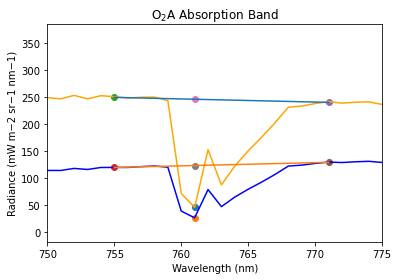

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_stressed_bean/Lo_spectrum_inclF.csv


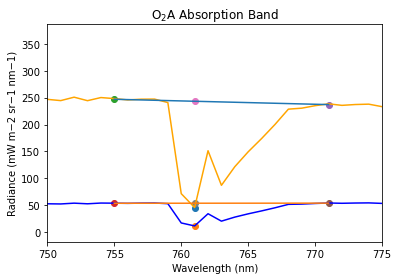

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_unstressed_bean/Lo_spectrum_inclF.csv


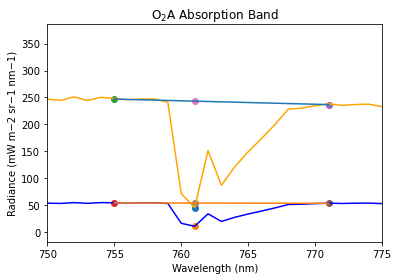

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_stressed_wheat/Lo_spectrum_inclF.csv


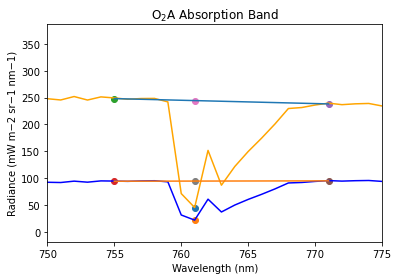

In [132]:
# get the spectras from the files and apply sFLD, 3FLD and iFLD to the original and resampled spectras
# fetch the SIF at the O2A band for each spectra
retrieved_flourescence = []
actual_fluorescence = []
retrieved_convoluted_fluorescence = []
three_fld_retrieved = []
three_fld_convoluted = []
i_fld_retrieved = []
i_fld_convoluted = []

for i in range(len(e_sky_pathnames)):
    print(l_pathnames[i])
    # get the E and L spectra
    # using just sun or sky and sun gives different results
    e_spectra = get_simulated_spectral_df(e_sky_pathnames[i]) + get_simulated_spectral_df(e_sun_pathnames[i])
    l_spectra = get_simulated_spectral_df(l_pathnames[i])
    e_spectra = np.asarray(e_spectra.iloc[0])
    l_spectra = np.asarray(l_spectra.iloc[0])
    
    resampled_e_spectra, re_wave = resample_spectra(fwhm = 3.26, spectra = e_spectra)
    resampled_l_spectra = resample_spectra(fwhm=3.26, spectra = l_spectra)[0]
    
    resampled_e_spectra = add_noise(255, resampled_e_spectra)
    resampled_l_spectra = add_noise(255, resampled_l_spectra)
    
    # apply the sFLD method
    retrieved_flourescence.append(sFLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1, plot = False))
    retrieved_convoluted_fluorescence.append(sFLD(resampled_e_spectra, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False))
    three_fld_retrieved.append(three_FLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1))
    three_fld_convoluted.append(three_FLD(resampled_e_spectra / np.pi, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False))
    i_fld_retrieved.append(iFLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1, plot = False))
    i_fld_convoluted.append(iFLD(resampled_e_spectra / np.pi, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False))
    
    
    # get actual F
    f_df = pd.read_csv(f_pathnames[i])
    f_df = f_df.iloc[2:]
    f_df.index = [0]
    f_761 = pd.to_numeric(f_df['F761'])
    actual_fluorescence.append(f_761.iloc[0])

# Define the RMSE and R$^2$ goodness-of-fit statistics

In [133]:
# now calculate quality of fit statistics

def rmse(y_actual, y_predicted):
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean()
    RMSE = np.sqrt(MSE)
    return(RMSE)

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(actual_fluorescence, retrieved_flourescence)

import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2
    

# Plot the result of each method and the goodness-of-fit statisitics

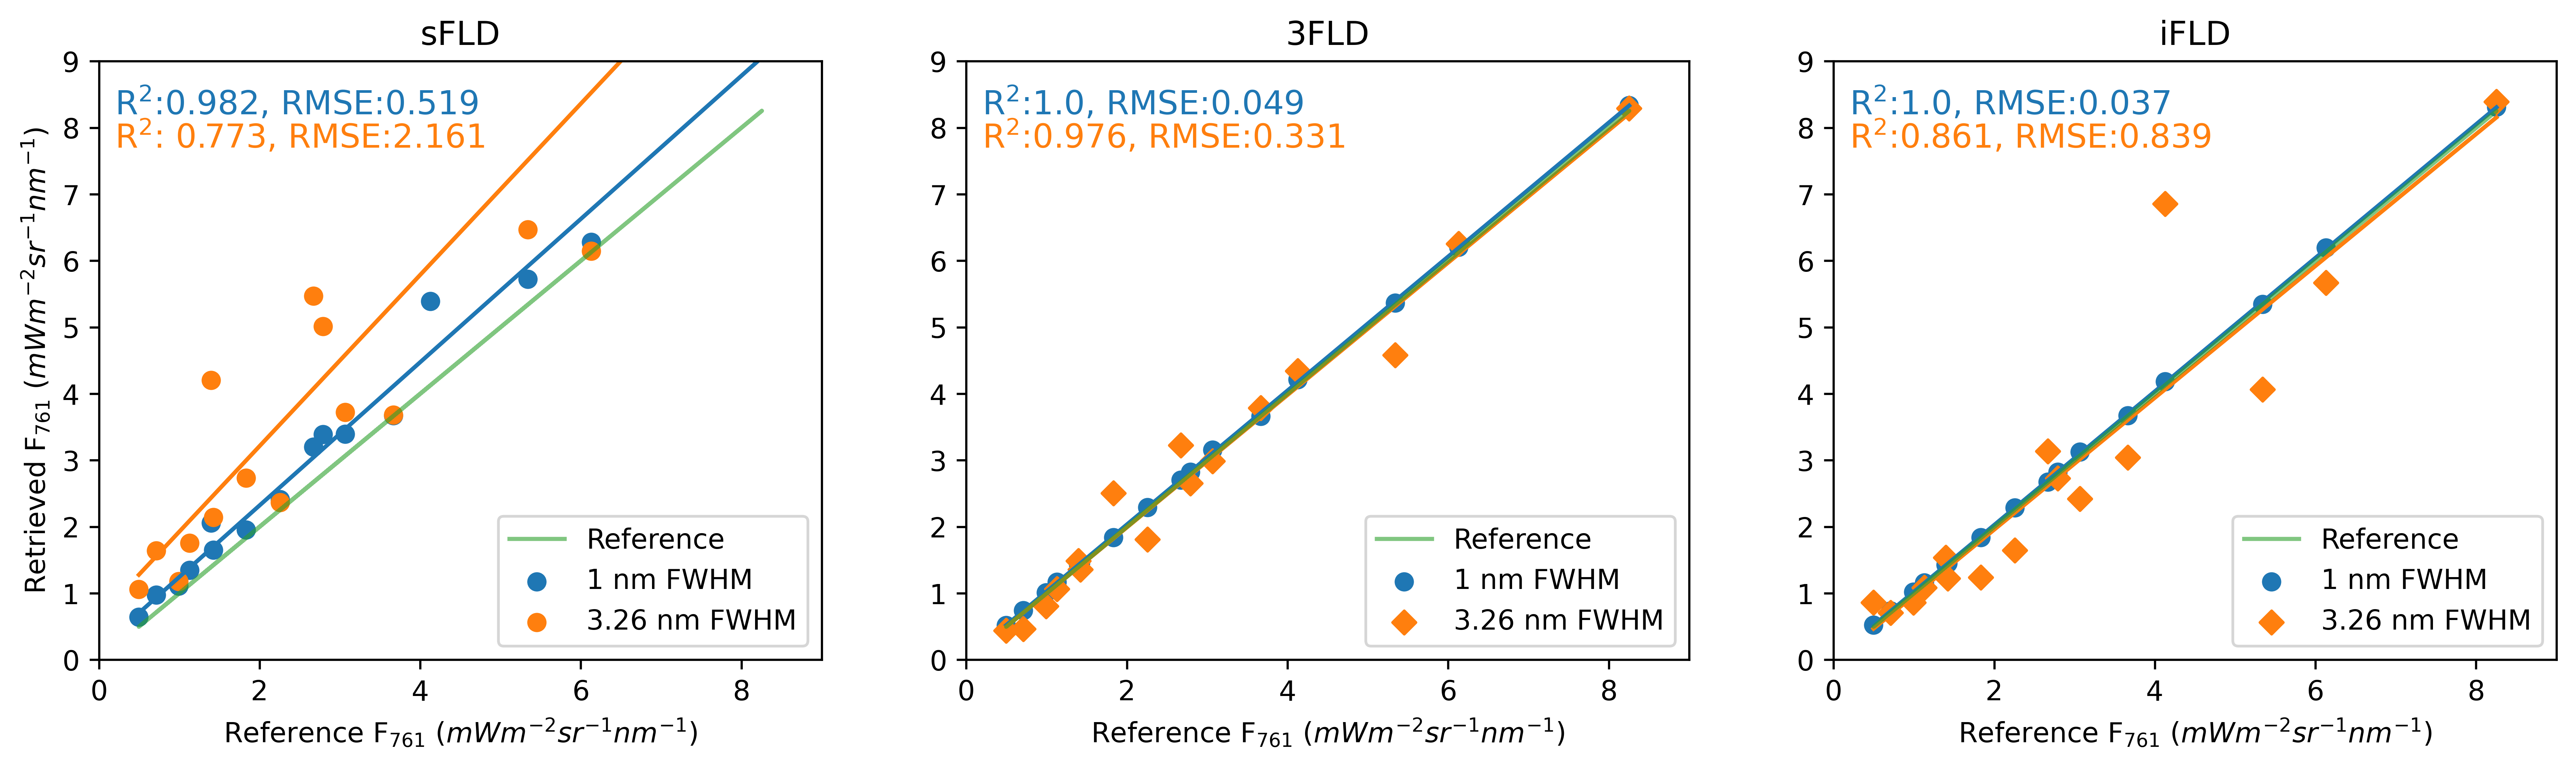

In [134]:
# now plot retrieved against actual and the goodness of fit statisitics

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4), dpi=600)

# plot sFLD results
ax1.scatter(actual_fluorescence, retrieved_flourescence, label = '1 nm FWHM')
ax1.scatter(actual_fluorescence, retrieved_convoluted_fluorescence, label = '3.26 nm FWHM')
ax1.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_flourescence, 1))(np.unique(actual_fluorescence)))
ax1.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_convoluted_fluorescence, 1))(np.unique(actual_fluorescence)))
ax1.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', alpha = 0.6, linestyle = '-')
ax1.set_xlabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax1.set_ylabel('Retrieved F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax1.set_xlim(0, 9)
ax1.set_ylim(0, 9)
ax1.set_title('sFLD')
ax1.text(x = 0.2, y = 8.2, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, retrieved_flourescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_flourescence), 3)), color = '#1f77b4', fontsize = 12)
ax1.text(x = 0.2, y = 7.7, s = 'R$^2$: '+ str(round(rsquared(actual_fluorescence, retrieved_convoluted_fluorescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_convoluted_fluorescence), 3)), color = 'C1', fontsize = 12)
ax1.legend(loc = 'lower right')

# plot 3FLD results
ax2.scatter(actual_fluorescence, three_fld_retrieved, label = '1 nm FWHM')
ax2.scatter(actual_fluorescence, three_fld_convoluted, label = '3.26 nm FWHM', marker = 'D')
ax2.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_retrieved, 1))(np.unique(actual_fluorescence)))
ax2.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_convoluted, 1))(np.unique(actual_fluorescence)))
ax2.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', alpha = 0.6, linestyle = '-')
ax2.set_xlabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
#ax2.set_ylabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax2.set_xlim(0, 9)
ax2.set_ylim(0, 9)
ax2.set_title('3FLD')

ax2.text(x = 0.2, y = 8.2, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, three_fld_retrieved), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_retrieved), 3)), color = '#1f77b4', fontsize = 12)
ax2.text(x = 0.2, y = 7.7, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, three_fld_convoluted), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_convoluted), 3)), color = 'C1', fontsize = 12)

ax2.legend(loc='lower right')

# plot iFLD results
# produce basic plot
ax3.scatter(actual_fluorescence, i_fld_retrieved, label = '1 nm FWHM')
ax3.scatter(actual_fluorescence, i_fld_convoluted, label = '3.26 nm FWHM', marker = 'D')
ax3.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, i_fld_retrieved, 1))(np.unique(actual_fluorescence)))
ax3.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, i_fld_convoluted, 1))(np.unique(actual_fluorescence)))
ax3.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', linestyle = '-', alpha = 0.6)
ax3.set_xlabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
#ax3.set_ylabel('Retrieved F761 (mW m-2 sr-1 nm-1)')
ax3.set_xlim(0, 9)
ax3.set_ylim(0, 9)
ax3.set_title('iFLD')

ax3.text(x = 0.2, y = 8.2, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, i_fld_retrieved), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, i_fld_retrieved), 3)), color = '#1f77b4', fontsize = 12)
ax3.text(x = 0.2, y = 7.7, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, i_fld_convoluted), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, i_fld_convoluted), 3)), color = 'C1', fontsize = 12)

ax3.legend(loc='lower right')

#plt.savefig('/Users/jameswallace/Desktop/EU_O2A.pdf', dpi=300)

# Calculate the relative errors for each method between the expected and retrieved fluorescence

In [135]:
# now plot relative error box and whisker

# relative_error = |(actual - expected) / expected| * 100 

def relative_error(retrieved, expected):
    error = (retrieved - expected) / expected
    rel_error = np.abs(error) * 100
    return(rel_error)

In [136]:
# get the relative errors for each method
sfld_rel_error = []
sfld_conv_rel_error = []
three_rel_error = []
three_conv_rel_error = []
ifld_rel_error = []
ifld_conv_rel_error = []
for i in range(len(retrieved_flourescence)):
    sfld_rel_error.append(relative_error(retrieved_flourescence[i], actual_fluorescence[i]))
    sfld_conv_rel_error.append(relative_error(retrieved_convoluted_fluorescence[i], actual_fluorescence[i]))
    three_rel_error.append(relative_error(three_fld_retrieved[i], actual_fluorescence[i]))
    three_conv_rel_error.append(relative_error(three_fld_convoluted[i], actual_fluorescence[i]))
    ifld_rel_error.append(relative_error(i_fld_retrieved[i], actual_fluorescence[i]))
    ifld_conv_rel_error.append(relative_error(i_fld_convoluted[i], actual_fluorescence[i]))

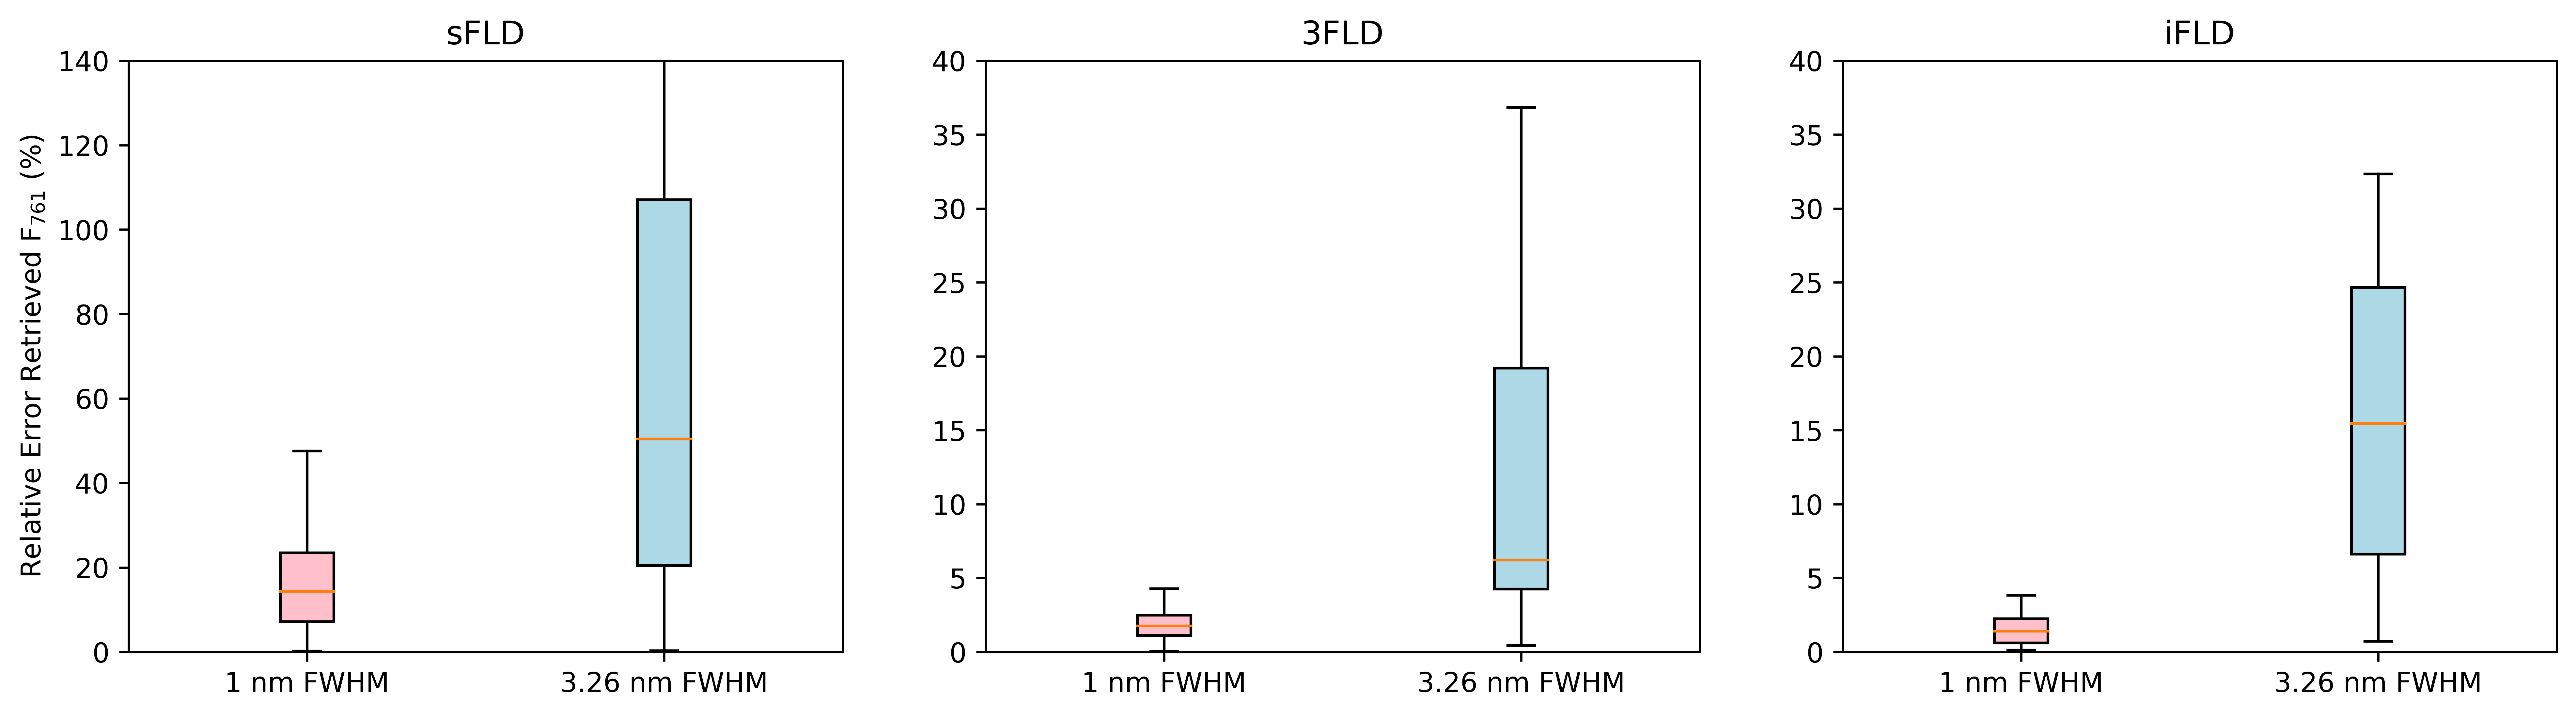

In [137]:
# plot box plots for the relative errors
fig, axes = plt.subplots(1, 3, figsize = (16, 4), dpi = 600)

labels = ['1 nm FWHM', '3.26 nm FWHM']

data1 = [sfld_rel_error, sfld_conv_rel_error]
data2 = [three_rel_error, three_conv_rel_error]
data3 = [ifld_rel_error, ifld_conv_rel_error]

bplot1 = axes[0].boxplot(data1, vert = True, patch_artist = True, labels = labels, showfliers = False)

plt.xticks(rotation= 90)
axes[0].set_title('sFLD')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(0)

axes[0].set_ylim(0, 140)
axes[0].set_ylabel('Relative Error Retrieved F$_{761}$ (%)')

bplot2 = axes[1].boxplot(data2, notch = False, vert = True, patch_artist = True, labels = labels, showfliers = False)

bplot3 = axes[2].boxplot(data3, notch = False, vert = True, patch_artist = True, labels = labels, showfliers = False)


colors = ['pink', 'lightblue', 'lightgreen', 'k', 'r', 'g', 'm', 'y', 'w']
for bplot in (bplot1, bplot2, bplot3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

for tick in axes[1].get_xticklabels():
    tick.set_rotation(0)
    
for tick in axes[2].get_xticklabels():
    tick.set_rotation(0)

axes[1].set_ylim(0, 40)
axes[2].set_ylim(0, 40)
axes[1].set_title('3FLD')
axes[2].set_title('iFLD')

#axes[2].set_ylim(0, 70)



plt.show()

#plt.savefig('/Users/jameswallace/Desktop/EU_O2A_rel_error.pdf', dpi=300)

In [143]:
np.median(ifld_conv_rel_error)

15.445166618686669

# Repeat for the O2B absorption band

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_unstressed_bean/Lo_spectrum_inclF.csv


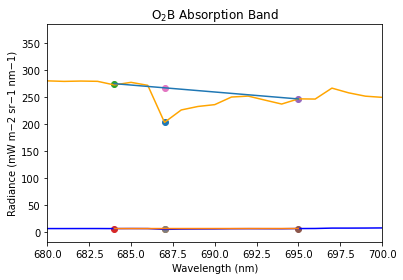

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_stressed_wheat/Lo_spectrum_inclF.csv


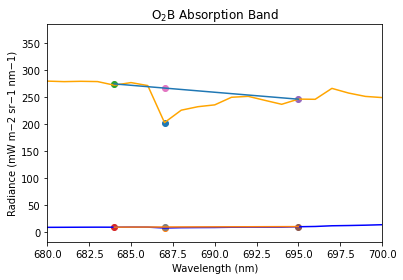

/Users/jameswallace/Desktop/SCOPE_crops/sparse_old_unstressed_bean/Lo_spectrum_inclF.csv


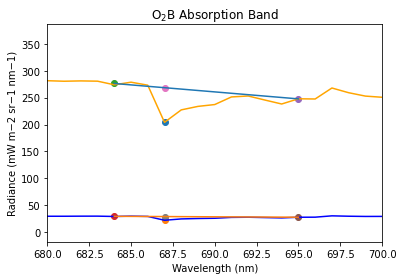

/Users/jameswallace/Desktop/SCOPE_crops/dense_midold_stressed_bean/Lo_spectrum_inclF.csv


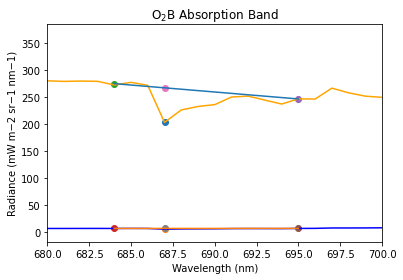

/Users/jameswallace/Desktop/SCOPE_crops/dense_senescent_stressed_wheat/Lo_spectrum_inclF.csv


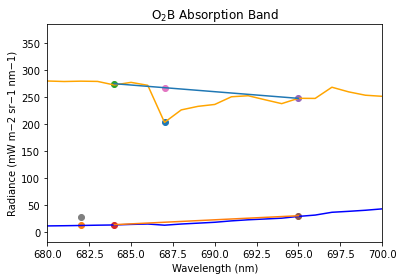

/Users/jameswallace/Desktop/SCOPE_crops/sparse_young_stressed_bean/Lo_spectrum_inclF.csv


KeyboardInterrupt: 

In [126]:
# get the spectras from the files and apply sFLD, 3FLD and iFLD to the original and resampled spectras
# fetch the SIF at the O2A band for each spectra
retrieved_flourescence = []
actual_fluorescence = []
retrieved_convoluted_fluorescence = []
three_fld_retrieved = []
three_fld_convoluted = []
i_fld_retrieved = []
i_fld_convoluted = []

for i in range(len(e_sky_pathnames)):
    print(l_pathnames[i])
    # get the E and L spectra
    # using just sun or sky and sun gives different results
    e_spectra = get_simulated_spectral_df(e_sky_pathnames[i]) + get_simulated_spectral_df(e_sun_pathnames[i])
    l_spectra = get_simulated_spectral_df(l_pathnames[i])
    e_spectra = np.asarray(e_spectra.iloc[0])
    l_spectra = np.asarray(l_spectra.iloc[0])
    
    resampled_e_spectra, re_wave = resample_spectra(fwhm = 3.26, spectra = e_spectra)
    resampled_l_spectra = resample_spectra(fwhm=3.26, spectra = l_spectra)[0]
    
    resampled_e_spectra = add_noise(255, resampled_e_spectra)
    resampled_l_spectra = add_noise(255, resampled_l_spectra)
    
    # apply the sFLD method
    retrieved_flourescence.append(sFLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1, plot = False, band = 'B'))
    retrieved_convoluted_fluorescence.append(sFLD(resampled_e_spectra, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False, band = 'B'))
    three_fld_retrieved.append(three_FLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1, band = 'B'))
    three_fld_convoluted.append(three_FLD(resampled_e_spectra / np.pi, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False, band = 'B'))
    i_fld_retrieved.append(iFLD(e_spectra / np.pi, l_spectra, np.arange(400, 2562), fwhm = 1, plot = False, band = 'B'))
    i_fld_convoluted.append(iFLD(resampled_e_spectra / np.pi, resampled_l_spectra, re_wave, fwhm = 3.5, plot = False, band = 'B'))
    
    
    # get actual F
    f_df = pd.read_csv(f_pathnames[i])
    f_df = f_df.iloc[2:]
    f_df.index = [0]
    f_684 = pd.to_numeric(f_df['F684'])
    actual_fluorescence.append(f_684.iloc[0])

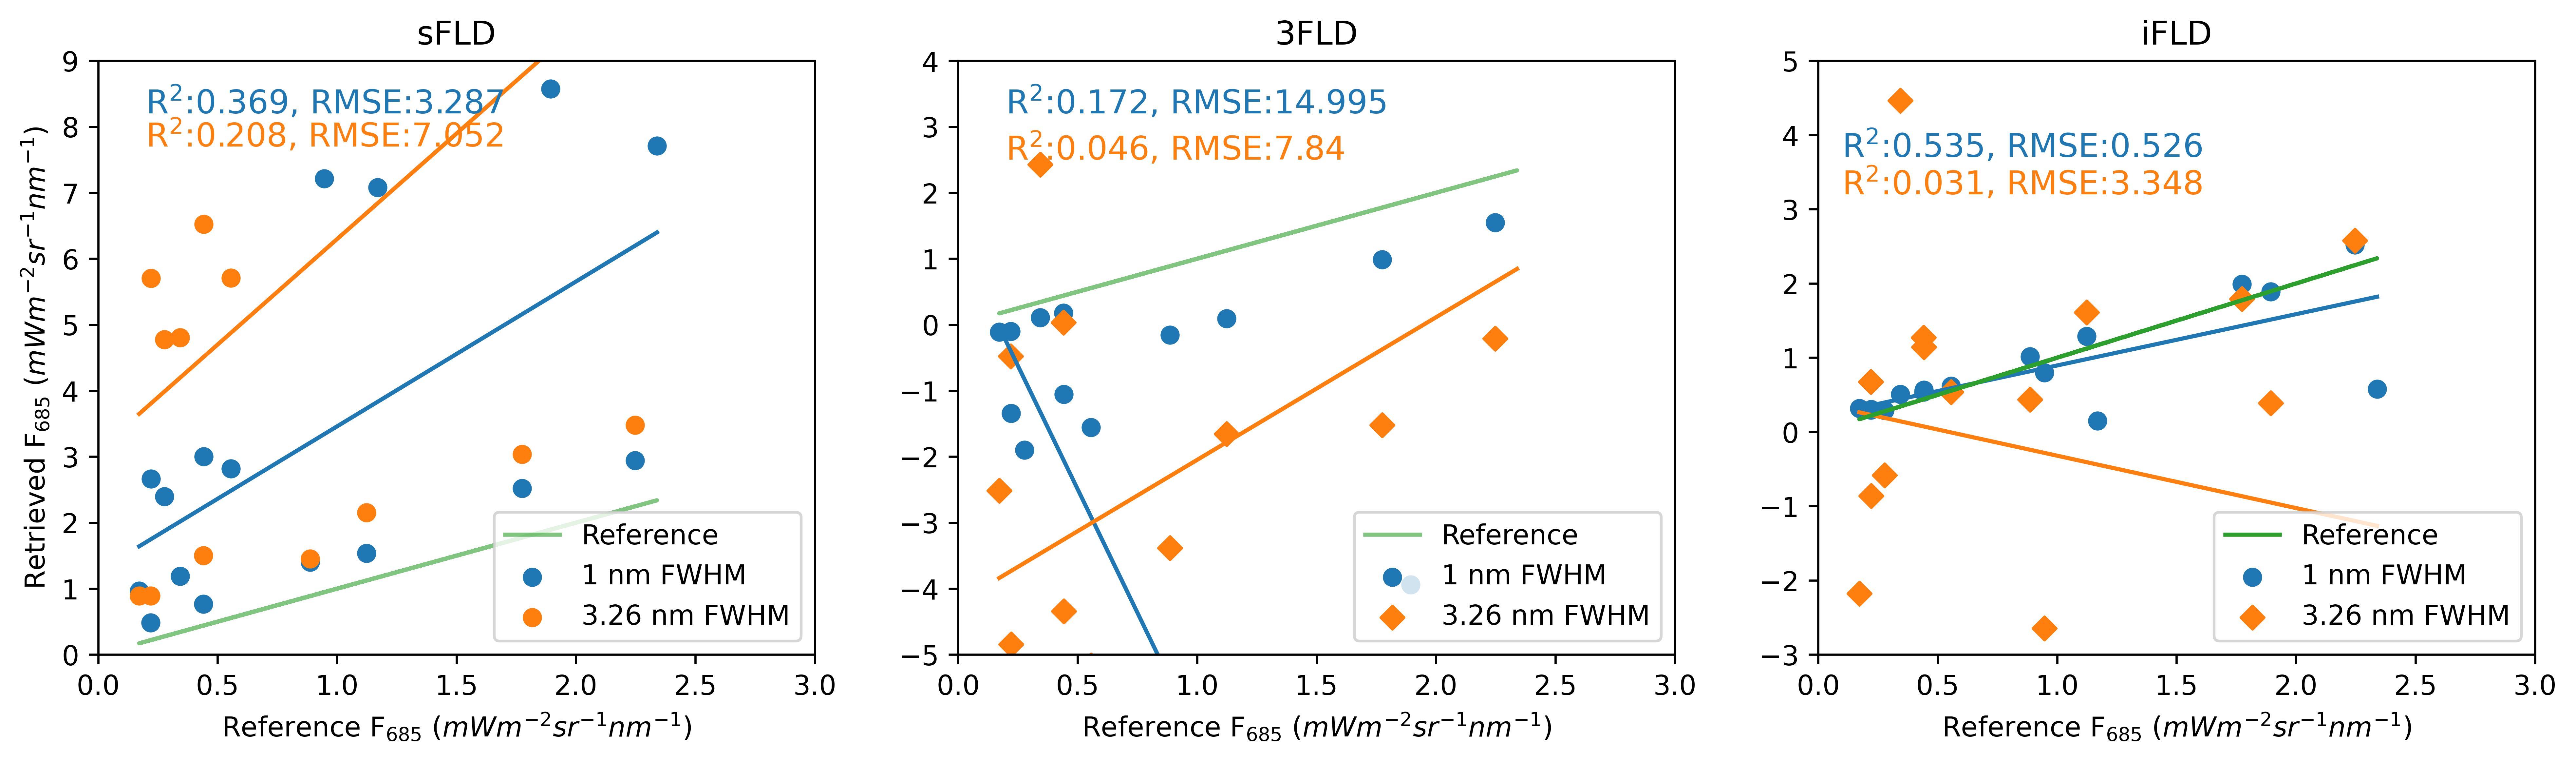

In [97]:
# now plot retrieved against actual and the goodness of fit statisitics

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4), dpi = 600)

# plot sFLD results
ax1.scatter(actual_fluorescence, retrieved_flourescence, label = '1 nm FWHM')
ax1.scatter(actual_fluorescence, retrieved_convoluted_fluorescence, label = '3.26 nm FWHM')
ax1.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_flourescence, 1))(np.unique(actual_fluorescence)))
ax1.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, retrieved_convoluted_fluorescence, 1))(np.unique(actual_fluorescence)))
ax1.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', alpha = 0.6)
ax1.set_xlabel('Reference F$_{685}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax1.set_ylabel('Retrieved F$_{685}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 9)
ax1.set_title('sFLD')
ax1.text(x = 0.2, y = 8.2, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, retrieved_flourescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_flourescence), 3)), color = '#1f77b4', fontsize = 12)
ax1.text(x = 0.2, y = 7.7, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, retrieved_convoluted_fluorescence), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, retrieved_convoluted_fluorescence), 3)), color = 'C1', fontsize = 12)
ax1.legend(loc = 'lower right')

# plot 3FLD results
ax2.scatter(actual_fluorescence, three_fld_retrieved, label = '1 nm FWHM')
ax2.scatter(actual_fluorescence, three_fld_convoluted, label = '3.26 nm FWHM', marker = 'D')
ax2.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_retrieved, 1))(np.unique(actual_fluorescence)))
ax2.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, three_fld_convoluted, 1))(np.unique(actual_fluorescence)))
ax2.plot(actual_fluorescence, actual_fluorescence, label = 'Reference', alpha = 0.6)
ax2.set_xlabel('Reference F$_{685}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
#ax2.set_ylabel('Reference F$_{761}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
ax2.set_xlim(0, 3)
ax2.set_ylim(-5, 4)
ax2.set_title('3FLD')

ax2.text(x = 0.2, y = 3.2, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, three_fld_retrieved), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_retrieved), 3)), color = '#1f77b4', fontsize = 12)
ax2.text(x = 0.2, y = 2.5, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, three_fld_convoluted), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, three_fld_convoluted), 3)), color = 'C1', fontsize = 12)

ax2.legend(loc='lower right')

# plot iFLD results
# produce basic plot
ax3.scatter(actual_fluorescence, i_fld_retrieved, label = '1 nm FWHM')
ax3.scatter(actual_fluorescence, i_fld_convoluted, label = '3.26 nm FWHM', marker = 'D')
ax3.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, i_fld_retrieved, 1))(np.unique(actual_fluorescence)))
ax3.plot(np.unique(actual_fluorescence), np.poly1d(np.polyfit(actual_fluorescence, i_fld_convoluted, 1))(np.unique(actual_fluorescence)))
ax3.plot(actual_fluorescence, actual_fluorescence, label = 'Reference')
ax3.set_xlabel('Reference F$_{685}$ ($mW m^{-2} sr^{-1} nm^{-1}$)')
#ax3.set_ylabel('Retrieved F761 (mW m-2 sr-1 nm-1)')
ax3.set_xlim(0, 3)
ax3.set_ylim(-3, 5)
ax3.set_title('iFLD')

ax3.text(x = 0.1, y = 3.7, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, i_fld_retrieved), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, i_fld_retrieved), 3)), color = '#1f77b4', fontsize = 12)
ax3.text(x = 0.1, y = 3.2, s = 'R$^2$:' + str(round(rsquared(actual_fluorescence, i_fld_convoluted), 3)) + ', RMSE:' + str(round(rmse(actual_fluorescence, i_fld_convoluted), 3)), color = 'C1', fontsize = 12)

ax3.legend(loc='lower right')

In [95]:
# get the relative errors for each method
sfld_rel_error = []
sfld_conv_rel_error = []
three_rel_error = []
three_conv_rel_error = []
ifld_rel_error = []
ifld_conv_rel_error = []
for i in range(len(retrieved_flourescence)):
    sfld_rel_error.append(relative_error(retrieved_flourescence[i], actual_fluorescence[i]))
    sfld_conv_rel_error.append(relative_error(retrieved_convoluted_fluorescence[i], actual_fluorescence[i]))
    three_rel_error.append(relative_error(three_fld_retrieved[i], actual_fluorescence[i]))
    three_conv_rel_error.append(relative_error(three_fld_convoluted[i], actual_fluorescence[i]))
    ifld_rel_error.append(relative_error(i_fld_retrieved[i], actual_fluorescence[i]))
    ifld_conv_rel_error.append(relative_error(i_fld_convoluted[i], actual_fluorescence[i]))

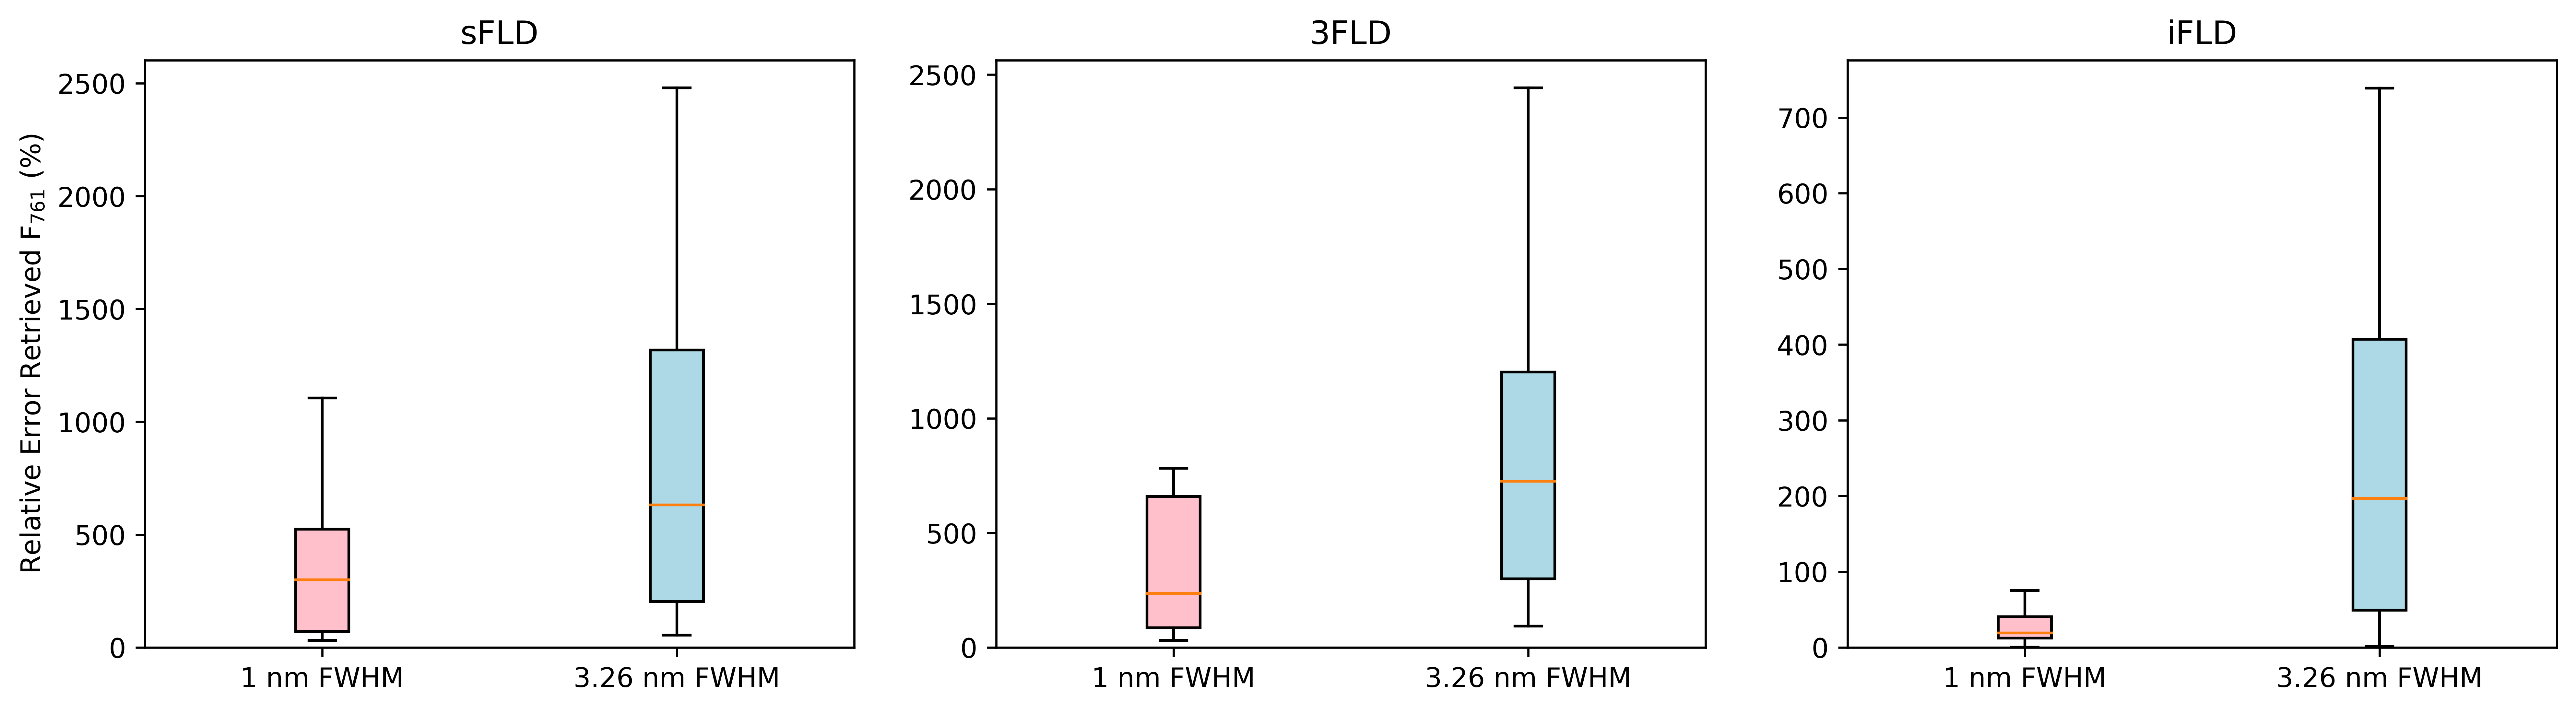

In [102]:
# plot box plots for the relative errors
fig, axes = plt.subplots(1, 3, figsize = (16, 4), dpi = 600)

labels = ['1 nm FWHM', '3.26 nm FWHM']

data1 = [sfld_rel_error, sfld_conv_rel_error]
data2 = [three_rel_error, three_conv_rel_error]
data3 = [ifld_rel_error, ifld_conv_rel_error]

bplot1 = axes[0].boxplot(data1, vert = True, patch_artist = True, labels = labels, showfliers = False)

plt.xticks(rotation= 90)
axes[0].set_title('sFLD')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(0)

#axes[0].set_ylim(0, 150)
axes[0].set_ylabel('Relative Error Retrieved F$_{761}$ (%)')

bplot2 = axes[1].boxplot(data2, notch = False, vert = True, patch_artist = True, labels = labels, showfliers = False)

bplot3 = axes[2].boxplot(data3, notch = False, vert = True, patch_artist = True, labels = labels, showfliers = False)


colors = ['pink', 'lightblue', 'lightgreen', 'k', 'r', 'g', 'm', 'y', 'w']
for bplot in (bplot1, bplot2, bplot3):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

for tick in axes[1].get_xticklabels():
    tick.set_rotation(0)
    
for tick in axes[2].get_xticklabels():
    tick.set_rotation(0)

#axes[1].set_ylim(0, 80)
#axes[2].set_ylim(0, 80)
axes[1].set_title('3FLD')
axes[2].set_title('iFLD')

for i in range(3):
    axes[i].set_ylim(0)


plt.show()




In [114]:
np.median(sfld_conv_rel_error)

631.6999410562019